In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

np.random.seed(0)

In [2]:
# 初始化环境并玩一步

env = gym.make('Taxi-v3')
env.seed(0)

state = env.reset()
taxirow, taxicol, passloc, destidx = env.unwrapped.decode(state)

print('出租车位置 = {}'.format((taxirow, taxicol)))
print('乘客位置 = {}'.format(env.unwrapped.locs[passloc]))
print('目标位置 = {}'.format(env.unwrapped.locs[destidx]))

env.render()
env.step(1)

出租车位置 = (0, 1)
乘客位置 = (0, 4)
目标位置 = (4, 0)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



(26, -1, False, {'prob': 1.0})

In [3]:
# SARSA算法智能体的实现

class SARSAAgent(object):
    
    def __init__(self, env, gamma=0.9, learning_rate=0.1, epsilon=0.01):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.action_n = env.action_space.n
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
        return

    def decide(self, state):
        if np.random.uniform() > self.epsilon:
            action = self.q[state].argmax()
        else:
            action = np.random.randint(self.action_n)
        return action

    def learn(self, state, action, reward, next_state, done, next_action):
        u = reward + self.gamma * self.q[next_state, next_action] * (1.0 - done)
        td_error = u - self.q[state, action]
        self.q[state, action] += self.learning_rate * td_error
        return

In [4]:
# SARSA智能体与环境交互一回合

def play_sarsa(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    action = agent.decide(observation)
    
    while True:
        if render:
            env.render()
        
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        next_action = agent.decide(next_observation)
        
        if train:
            agent.learn(observation, action, reward, next_observation, done, next_action)
        
        if done:
            break
        
        observation, action = next_observation, next_action

    return episode_reward

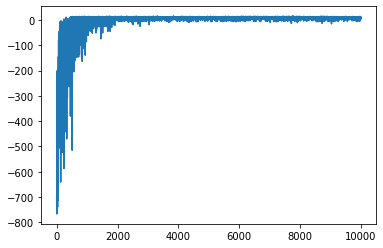

In [5]:
# 训练SARSA算法

agent = SARSAAgent(env)

episodes = 10000
episode_rewards = []
for episode in tqdm(range(episodes)):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards)

In [6]:
# 测试SARSA算法

agent.epsilon = 0.0
episode_rewards = [play_sarsa(env, agent) for _ in range(100)]
print('平均回合奖励 = {} '.format(np.mean(episode_rewards)))

平均回合奖励 = 8.11 


In [7]:
# 显示最优价值估计

pd.DataFrame(agent.q)

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-3.028923,-3.035849,-3.473541,-3.072329,1.133675,-5.082341
2,-0.577135,-1.271961,-1.414977,-1.281007,7.172636,-3.865790
3,-2.206421,-3.008951,-3.028152,-3.405872,2.430150,-4.972073
4,-5.512732,-6.044403,-5.960489,-6.001211,-7.386889,-7.398045
...,...,...,...,...,...,...
495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
496,-2.515656,-2.392497,-2.393122,-1.465809,-3.764710,-3.772972
497,-1.258346,-1.006706,-1.270159,-1.141122,-1.900000,-1.909000
498,-2.360109,-2.400347,-2.441104,-2.357097,-3.764322,-4.596034


In [8]:
# 显示最优策略估计

policy = np.eye(agent.action_n)[agent.q.argmax(axis=-1)]
pd.DataFrame(policy)

,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
495,1.0,0.0,0.0,0.0,0.0,0.0
496,0.0,0.0,0.0,1.0,0.0,0.0
497,0.0,1.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,1.0,0.0,0.0
